# XGBoost = Linear Regression + Tree Model
# 모델의 종류
  - Booster(gblinear( L0, L1, L2 ), gbtree( max_depth ), dart( early-stooping ))
  - Booster Wrapper model ( XGBClassifier, XGBRegressor )
# 데이터 처리
  - Booster -> DBatrix( 독립변수 + 종속변수 결합 입력 )
  - Booster Wrapper Model -> ndarray, DataFrame ( 분리해서 입력 )


In [ ]:
# data : 특정 값으로 이루어진 2차원 리스트 ( 3개의 샘플, 3개의 특성 )
# label : 각 샘플에 대한 정답값(타겟, 라벨)
# DMatrix = XGBoost에서 학습 데이터 다룰 떼 사용하는 최적화된 데이터 구조

In [ ]:
import xgboost as xgb
data = [[1,2,3], [4,5,6,],[7,8,9]] # 입체적 3*3
# 종속변수
label = [1, 0 ,1] # 1*3
dmatrix = xgb.DMatrix(data, label) # DMatrix 객체로 변환
label = dmatrix.get_label() # 함수로 제어
print(label)

[1. 0. 1.]


In [ ]:
xgb.__version__ # 버전 확인

'2.1.4'

In [ ]:
# numpy 하고 비슷 ( 희소행렬을 다루기 위해서 )
# 인덱스 + 데이터
data = dmatrix.get_data()
# get_data -> DMatrix 객체 저장된 특징 데이터 반환
print(data)
dmatrix.save_binary('data.dmatrix') # 이진 저장
# save_binary('파일명') -> DMatrix 객체 파일로 저장할 수 있음
# 저장된 파일은 나중에 다시 불러와 학습에 사용할 수 있음
dmatrix = xgb.DMatrix('data.dmatrix') # 로딩
# loc iloc[0,1]
sliced_dmatrix = dmatrix.slice([0,1],[0,1]) # sllice ([행 인덱스], [열 인덱스])
print(sliced_dmatrix)
print(sliced_dmatrix.get_data())

  (0, 0)	1.0
  (0, 1)	2.0
  (0, 2)	3.0
  (1, 0)	4.0
  (1, 1)	5.0
  (1, 2)	6.0
  (2, 0)	7.0
  (2, 1)	8.0
  (2, 2)	9.0
  (0, 0)	1.0
  (0, 1)	2.0
  (0, 2)	3.0
  (1, 0)	4.0
  (1, 1)	5.0
  (1, 2)	6.0


# DMatrix 특징
 - 연산 속도 빠르고 메모리 효율 좋음
 - 결측값 자동 처리 기능 포함
 - 병렬처리 지원

# 모델의 하이퍼파라미터 설정
 - max_depth : 트리의 최대 깊이
 - eta=1 : 학습률
 - objective=' multi:softmax ' : 다중 클래스 분류 모델 사용
 - num_class=3 : 예측해야 할 클래스 개수


In [ ]:
# iris 데이터셋 로드 및 데이터 분할 위한 라이브라리 불러오기~
# DMatrix는 XGBoost의 전용행렬
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split # 데이터를 학습, 테스트로 나누는 함수

data = load_iris()
X_train, X_test, y_train, y_test = train_test_split(
    data['data'], data['target'], test_size=.2) # test_size =0.2 -> 20%는 테스트 데이터, 80%는 학습 데이터로 분할
# XGBoost 에서는 DMatrix라는 데이터 구조 사용해 데이터 처리함
# 독립변수 + 종속변수 변환과정
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)
# dictionary 형태로 파라미터 전달
param = {'max_depth':2, 'eta':1, # param : XGBoost 모델의 하이퍼파라미터 설정
         'objective':'multi:softmax', 'num_class':3}
num_round = 2 # max_round=2 -> 부스팅 라운드 2번 반복하여 학습 진행
# scikits : fit
bst = xgb.train(param, dtrain, num_round)
    # xgb.train(파라미터, 학습 데이터, 반복 횟수)
    # 설정한 하이퍼파라미터 사용 -> dtrain 데이터로 num_round만큼 학습 진행
    # 학습 완료된 모델 bst 변수에 저장됨

# Dart (Drop Additive Regressioni Trees )
 - Dropout 적용 -> 일부 트리 랜덤 지외 학습 과적합 방지
 - 트리 정규화 -> Dropout 후 트리 가중치 조정 -> 안정적인 학습 유지
 - 기존 gbtree보다 일반화 성능 향상
 - 학습 속도 느릴 수 있음 -> Dropout 과정 추가되어 계산량 증가
 - 적절한 rate_drop, skip_drop 조정 필요 -> 너무 높은 값은 성능 저하 가능

 결론 : Dart는 Dropout 적용하여 과적합 방지, 일반화 성능 향상시키는 부스팅 방법

In [ ]:
# dart booster로 변경
# 딥러닝 개념 : 행렬연산시 몇 개의 연산은 무작위로 제외 ( 과적합 방지 위해 )
# dart booster에서의 dropout은 무작위 트리 비활성화
param = {'booster': 'dart', # 부스터 선택, Dart = Dropout 방식 적용한 과적합 방지용 부스팅 기법
         'max_depth':5, # 트리의 최대 깊이 설정 ( 값 크면 모델 복잡, 과적합 가능 )
         'learning_rate':0.1, # 학습률 설정 ( 낮을수록 학습 천천히 진행 -> 안정적 )
         'objective':'multi:softmax', # 다중 클래스 분류 문제 풀기 위한 설정
         'num_class':3, # 클래스의 개수 ( iris 데이터셋에서는 3개 클래스 )
         'sample_type': 'uniform', # 드롭아웃할 트리 균등(uniform)하게 선택, 가중치 균등
         'normalize_type':'tree', # Dropout 후 점수를 트리 단위 정규화, 가중치 정규화하는 방법
         'rate_drop':0.1, # 드롭아웃할 확률 ( 값 크면 더 많은 트리 랜덤하게 제외 )
         'skip_drop':0.5 } # 개별 트리 건너뛸 확률 ( 값 크면 모델 더 단순해짐 )
num_round = 50
bst = xgb.train(param, dtrain, num_round)

# XGBoost 하이퍼파라미터
-----------------------------------------------------
 < 트리 구조 관련 하이퍼파라미터 >
 - n_estimators = 부스팅 반복 횟수 ( 트리 개수 )
 - num_boost_round = n_estimators와 동일
 - max_depth = 트리 최대 깊이
 - min_child_weight = 리프 노드 최소 가중치
 - gamma = 새로운 분할 만들기 위한 최소 손실 감소량
 - colsample_bytree = 트리 생성 시 사용할 특징 비율
 - colsample_bylevel = 각 레벨에서 사용할 특징 비율
 - colsample_bynode = 각 노드에서 사용할 특징 비율
-----------------------------------------------------
 < 학습률 및 규제 ( 과적합 방지 ) >
 - learning_rate (eta) = 학습률
 - subsample = 학습할 때 사용할 샘플 데이터 비율 ( 과적합 방지 )
 - reg_alpha = L1 정규화 ( 불필요한 변수 제거 ) / L1 = 라쏘 모델
 - reg_lambda = L2 정규화 ( 가중치 감소로 과적합 방지 ) / L2 = 릿지 모델
-----------------------------------------------------
 < 기타 성능 최적화 관련 하이퍼파라미터 >
 - objective = 목적 함수 설정
   - binary:logixtic = 이진 분류
   - multi:softmax = 다중 분류
 - num_class = 다중 분류 시 클래스 개수 지정
 - scale_pos_weight = 클래스 불균형이 심할 때 사용 ( 1보다 크면 소수 클래스 강조 )

In [ ]:
from xgboost import XGBClassifier
# Booster wrrapper 한 모델
# scikit-learn 방식으로 사용
xcl = XGBClassifier(n_estimators=2, max_depth=2,
                    learning_rate=1, num_class=3,
                    objective='multi:softmax')
xcl.fit(X_train, y_train)
preds = xcl.predict(X_test)
xcl.score(X_test, y_test)

0.9333333333333333

In [ ]:
# 문제 : 위의 dart 부스터로 변경해서 XGBClassifier를 동작해 보시오
# num_round = 50
model = xgb.XGBClassifier(
    booster='dart', max_depth =5, learning_rate=0.1,
    objective = 'multi:softmax', num_class=3,
    sample_type = 'uniform',
    normalize_type = 'tree', rate_drop=0.1, skip_drop=0.5
)
model.fit(X_train, y_train)
preds = model.predict(X_test)
model.score(X_test, y_test)

0.9333333333333333

In [ ]:
import pandas as pd
import numpy as np
# 내장데이터 ->
data_url = "http://lib.stat.cmu.edu/datasets/boston"
title = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'RAD' , 'TAX', 'PTRATIO', 'B', 'LSTAT',  'medv']
raw_df = pd.read_csv(data_url, sep='\s+', skiprows=22, header = None) # 22행 부터
# horizontal 수평으로 ( 하나의 데이터가 2행에 저장 )
data = np.hstack([raw_df.values[::2,:], # 짝수행은 다
                  raw_df.values[1::2, :2]]) # 홀수행은 1,2열만
target = raw_df.values[1::2,2] # 1행 홀수행부터 2칸씩 건너뛰면서
print(type(data))
boston_df = pd.DataFrame(data, columns = title)
boston_df.head()

<class 'numpy.ndarray'>


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,RAD,TAX,PTRATIO,B,LSTAT,medv
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [ ]:
X=boston_df.iloc[:, :12] # 12개의 특성(feature) 선택
print(X.shape) # 506개의 샘플, 12개의 특성
y = boston_df.iloc[:, 12] # 타겟 변수 (집값)
y.shape
from sklearn.metrics import mean_squared_error
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=123)
# random_state=123 -> 랜덤 시즈 설정 ( 결과 재현 가능하게 )

(506, 12)


In [ ]:
# 회귀
# booster 선택과 objective는 무관
# 선형회귀나 트리모델 : 분류, 예측이 가능
# 열선택분리할 때 : colsample_bytree
# 규제 : alpha(L1), beta(L2), gamma (L0)
xg_reg = xgb.XGBRegressor(booster='gbtree', # 트리 기반 부스팅 사용
                          objective = 'reg:squarederror', # 회귀 문제 위한 목적 함
                          colsample_bytree = 0.3,  # 랜덤하게 선택할 feature 비율
                          learning_rate = 0.1, # 학습
                          max_depth = 5, # 트리 최대 깊이
                          alpha = 10, # L1 정규화 ( 불필요한 feature 줄여서 과적합 방지 )
                          n_estimators = 20) # 트리 개수 ( 반복 학습 횟수 )
xg_reg.fit(X_train, y_train)
preds = xg_reg.predict(X_test)
# MSE 값
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse)) # root mean squared error

RMSE: 4.961375


In [ ]:
!apt-get -qq install -y graphviz && pip install -q pydot
!apt-get install graphviz libgraphviz-dev pkg-config
!pip install pygraphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
The following packages were automatically installed and are no longer required:
  libbz2-dev libpkgconf3 libreadline-dev
Use 'apt autoremove' to remove them.
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libgvc6-plugins-gtk
  librsvg2-common libxdot4
Suggested packages:
  gvfs
The following packages will be REMOVED:
  pkgconf r-base-dev
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4 pkg-config
0 upgraded, 10 newly installed, 2 to remove and 29 not upgraded.
Need to get 2,482 kB of archives.
After this operation, 7,671 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 pkg-config a

# 트리 출력 결과
  - 트리의 각 노드는 특정( RAD, PTRATIO, ZN을 기준으로 분할
  - 빨간색 선 : 높은 예측 값
  - 파란색 선 : 낮은 예측 값
  - 리프 노드 : 최종 예측 값
  - 트리의 깊이 max_depth=5로 설정되어 있어 5단계까지만 성장함

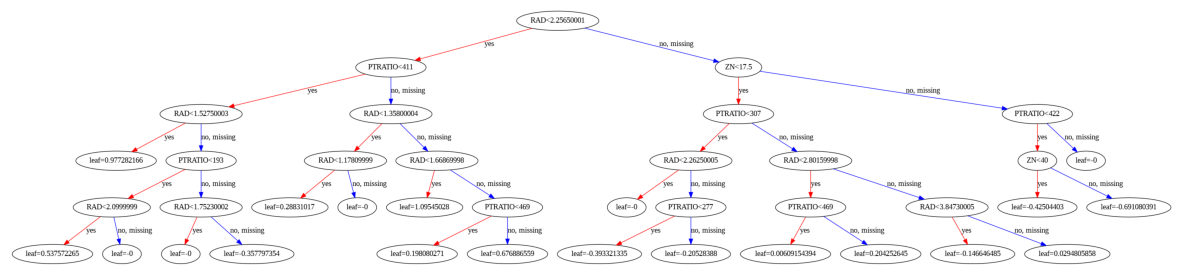

In [ ]:
import matplotlib.pyplot as plt
xgb.plot_tree(xg_reg, num_trees=0) # 학습된 xg_reg 모델의 첫 번쨰 트리 시각화
plt.rcParams['figure.figsize'] = [15, 60] # 그래프 크기 조절 ( 너비 15, 높이 60 )
plt.show()

In [ ]:
data_dmatrix = xgb.DMatrix(data=X, label=y)
# DMatrix는 내부적으로 메모리 효율적 관리, 결측치 처리 기능 내장됨 대박
params = {"objective":"reg:squarederror", # 회귀 문제 위한 목적 함수
          'colsample_bytree': 0.3,
          'learning_rate': 0.1,
          'max_depth': 5,
          'alpha': 10 } # L1 정규화 적응 ( 불필요한 feature 감소 )
# cross validation ( 교차 검증 )
cv_results = xgb.cv(dtrain=data_dmatrix, params=params,
                    nfold=3, # 3-FOLD 교차 검증 수행
                    num_boost_round=50, # 부스팅 반복 횟수( 트리 개수 )
                    early_stopping_rounds=10,
                    metrics='rmse', # 평가 지표 사
                    as_pandas=True, # 결과를 pandas 구조로
                    seed=123,
# callbacks 윈도우에서 이벤트 드리븐 프로그래밍
# 시스템이 호출 하는 함
                    callbacks=[xgb.callback.EvaluationMonitor(show_stdv=True)],)



[0]	train-rmse:6.75129+0.05441	test-rmse:6.82019+0.13762
[1]	train-rmse:6.40630+0.03029	test-rmse:6.53104+0.13838
[2]	train-rmse:6.09260+0.01323	test-rmse:6.29082+0.15014
[3]	train-rmse:5.86080+0.02939	test-rmse:6.12159+0.16615
[4]	train-rmse:5.62165+0.03553	test-rmse:5.93653+0.13593
[5]	train-rmse:5.38394+0.03948	test-rmse:5.75802+0.12321
[6]	train-rmse:5.25579+0.05007	test-rmse:5.65999+0.11301
[7]	train-rmse:5.06409+0.05239	test-rmse:5.52955+0.09936
[8]	train-rmse:4.88735+0.06385	test-rmse:5.40221+0.09753
[9]	train-rmse:4.63469+0.06177	test-rmse:5.21373+0.07699
[10]	train-rmse:4.54071+0.06969	test-rmse:5.13419+0.07287
[11]	train-rmse:4.42213+0.07748	test-rmse:5.05193+0.05810
[12]	train-rmse:4.29481+0.08628	test-rmse:4.97589+0.04683
[13]	train-rmse:4.24072+0.08316	test-rmse:4.93821+0.04273
[14]	train-rmse:4.18789+0.08693	test-rmse:4.89866+0.03851
[15]	train-rmse:4.09606+0.08285	test-rmse:4.84858+0.03358
[16]	train-rmse:3.93866+0.06845	test-rmse:4.73318+0.02802
[17]	train-rmse:3.86999+

In [ ]:
# num_boost_round를 확인
xg_reg = xgb.train(params=params,
                   dtrain=data_dmatrix, num_boost_round=215)

In [ ]:
# hyper parameter tunning
import scipy.stats as st
xgbreg = xgb.XGBRegressor(objective = 'reg:squarederror',
                          n_jobs=-1)
params = {
    'n_estimators': st.randint(3,40),
    'max_depth': st.randint(3,40),
    'learning_rate': st.uniform(0.05, 0.4),
    'gamma': st.uniform(0,10),
}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
gs = RandomizedSearchCV(xgbreg, params, n_jobs=1)
gs.fit(X_train, y_train)
gs.best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=1.3630924621656737, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.12165349410086011,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=24, n_jobs=-1,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
gs.best_params_

In [ ]:
import pandas as pd
file_path='/content/drive/MyDrive/Numpy/pima.csv'
df = pd.read_csv(file_path)

In [ ]:
df.head()

,Unnamed: 0,npreg,glu,bp,skin,bmi,ped,age,type
0,1,6,148,72,35,33.6,0.627,50,Yes
1,2,1,85,66,29,26.6,0.351,31,No
2,3,1,89,66,23,28.1,0.167,21,No
3,4,3,78,50,32,31.0,0.248,26,Yes
4,5,2,197,70,45,30.5,0.158,53,Yes


In [ ]:
df.columns

Index(['Unnamed: 0', 'npreg', 'glu', 'bp', 'skin', 'bmi', 'ped', 'age',
       'type'],
      dtype='object')

In [ ]:
##### 개인적으로 해본 거 ㅎ #####
# 전처리
# 0번열 제거
# type의 내용을 Yes는1, No는 0
# 독립변수와 종속변수를 분리
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# ✅ 1. 불필요한 'Unnamed: 0' 컬럼 제거 (자동 생성된 인덱스 컬럼일 가능성 높음)
if 'unnamed: 0' in df.columns:
    df.drop(columns=['unnamed: 0'], inplace=True)

# ✅ 2. 현재 컬럼 목록 확인
print("📌 현재 DataFrame의 컬럼 목록:", df.columns)

# ✅ 3. 'type' 관련 컬럼이 이미 존재하는지 확인
type_columns = [col for col in df.columns if 'type' in col]  # 'type' 관련 컬럼 찾기
print("🔹 현재 존재하는 type 관련 컬럼:", type_columns)

# ✅ 4. 추가적인 변환이 필요하지 않으면 그대로 사용
if 'type' not in df.columns and len(type_columns) > 0:
    print("✅ 'type' 컬럼이 이미 변환된 상태입니다. 추가 변환 없이 진행합니다.")
else:
    print("⚠️ 'type' 컬럼 변환이 필요합니다. 원-핫 인코딩을 수행합니다.")

    # 4-1. Yes/No 값을 1/0으로 변환
    df['type'] = df['type'].replace({'Yes': 1, 'No': 0})

    # 4-2. 결측값 채우기
    df['type'] = df['type'].fillna(0)  # 결측값을 0으로 대체

    # 4-3. OneHotEncoder 적용
    encoder = OneHotEncoder(sparse_output=False)  # 최신 버전 사용
    encoded_array = encoder.fit_transform(df[['type']])  # 2D 배열로 변환

    # 4-4. 원-핫 인코딩 결과를 새로운 DataFrame으로 변환
    encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(['type']))

    # 4-5. 기존 데이터프레임(df)과 병합
    df = df.drop(columns=['type'])  # 기존 'type' 컬럼 제거
    df = pd.concat([df, encoded_df], axis=1)  # 새로운 인코딩 컬럼 추가

# ✅ 5. 최종 변환된 DataFrame 출력
print("🔹 최종 변환된 DataFrame:")
print(df.head())  # 변환된 데이터 일부 출력


📌 현재 DataFrame의 컬럼 목록: Index(['npreg', 'glu', 'bp', 'skin', 'bmi', 'ped', 'age', 'type_0', 'type_1'], dtype='object')
🔹 현재 존재하는 type 관련 컬럼: ['type_0', 'type_1']
✅ 'type' 컬럼이 이미 변환된 상태입니다. 추가 변환 없이 진행합니다.
🔹 최종 변환된 DataFrame:
   npreg  glu  bp  skin   bmi    ped  age  type_0  type_1
0      6  148  72    35  33.6  0.627   50     0.0     1.0
1      1   85  66    29  26.6  0.351   31     1.0     0.0
2      1   89  66    23  28.1  0.167   21     1.0     0.0
3      3   78  50    32  31.0  0.248   26     0.0     1.0
4      2  197  70    45  30.5  0.158   53     0.0     1.0


In [ ]:
# 전처리
# 0번열 제거
# type의 내용을 Yes는1, No는 0
# 독립변수와 종속변수를 분리
X = df.iloc[:, 1:df.shape[1]-1]
print(X.shape)
print(X.head())
y = df.iloc[:, df.shape[1]-1]
y = np.where(y=='Yes', 1, 0)
y = pd.Series(y)

(332, 7)
   npreg  glu  bp  skin   bmi    ped  age
0      6  148  72    35  33.6  0.627   50
1      1   85  66    29  26.6  0.351   31
2      1   89  66    23  28.1  0.167   21
3      3   78  50    32  31.0  0.248   26
4      2  197  70    45  30.5  0.158   53


In [ ]:
# 데이터를 train 67%, test=33%로 분리
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=7)

In [ ]:
# 문제 : 다음 함수를 활용, 평가하시오
# 모델.score(), accurcy_score, cross_val_score()
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
model.score(X_test, y_test)

y_pred = model.predict(X_test) # 테스트 데이터 예측
print(y_pred)

accuracy = accuracy_score(y_test, y_pred)
print("테스트 정확도: %.2f%%" % (accuracy * 100.0))
cross_val_score(model, X_test, y_test) # 교차 검증 실행


[0 1 1 0 1 0 1 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1 0 1 1 0
 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 1
 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 0 1 0 0]
테스트 정확도: 73.64%


array([0.63636364, 0.72727273, 0.90909091, 0.81818182, 0.77272727])

In [ ]:
import xgboost as xgb
model = xgb.XGBClassifier(n_jobs = -1, # n_jobs -> 모든 CPU 코어 사용 ( 병렬 처리 )
                          learning_rate=0.1, # XGBClassifier() -> XGBoost 기반 분류 모델 생성
                          max_depth=3, # 트리의 최대 깊이 ( 값 클수록 복잡한 모델)
                          random_state=200) # 랜덤 시드 설정
model.fit(X_train, y_train) # 모델을 훈련 데이터로 학습
print(model)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=200, ...)


# thresholds = 모든 feature의 중요도 정렬한 리스트
# thresh = 이 리스트에서 하나씩 꺼내서 변수 선택의 기준으로 사용하는 값

In [ ]:
# 모델 선택 ( 변수선택법 )
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
print(model.feature_importances_) # 변수 중요도 출력
thresholds = np.sort(model.feature_importances_) # 중요도 기준
print(thresholds) # 정렬된 변수 중요도 출력
print(np.sum(thresholds)) # 중요도의 총합 확인

[0.10636207 0.31187716 0.06376134 0.10305764 0.14827058 0.0986028
 0.16806827]
[0.06376134 0.0986028  0.10305764 0.10636207 0.14827058 0.16806827
 0.31187716]
0.9999999


In [ ]:
# 변수 선택의 최적 상태 확인
# 변수 중요도를 경계선으로 모델 평가 ( 오름차순 )
import warnings
warnings.filterwarnings('ignore')
for thresh in thresholds: # 0.06376134, 0.0986028
  # 중요도가 경계선을 넘어서는 것만 선택
  selection = SelectFromModel(model, threshold=thresh,
                              prefit=True)
  select_X_train = selection.transform(X_train) # 변수제거
  selection_model = xgb.XGBClassifier( # 모델을 생성
      use_label_encoder=False)
  selection_model.fit(select_X_train, y_train) # 새로운 모델
  select_X_test = selection.transform(X_test)
  y_pred = selection_model.predict(select_X_test)
  predictions = [round(value) for value in y_pred]
  accuracy = accuracy_score(y_test, predictions)
  print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % ( thresh,
                                                 select_X_train.shape[1], accuracy*100.0))

Thresh=0.064, n=7, Accuracy: 70.91%
Thresh=0.099, n=6, Accuracy: 75.45%
Thresh=0.103, n=5, Accuracy: 73.64%
Thresh=0.106, n=4, Accuracy: 75.45%
Thresh=0.148, n=3, Accuracy: 72.73%
Thresh=0.168, n=2, Accuracy: 71.82%
Thresh=0.312, n=1, Accuracy: 76.36%


In [ ]:
# 정해진 경계선을 중심하고 새롭게 모델을 생성해 보시오
thresh = 0.106
selection = SelectFromModel(model, threshold=thresh,
                              prefit=True)
select_X_train = selection.transform(X_train) # 변수제거
selection_model = xgb.XGBClassifier( # 모델을 생성
     use_label_encoder=False)
selection_model.fit(select_X_train, y_train) # 새로운 모델
# 테스트 데이터도 변형
select_X_test = selection.transform(X_test)
y_pred = selection_model.predict(select_X_test)
# 소수점을 제거 ( 0, 1 )
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % ( thresh,
                                                 select_X_train.shape[1], accuracy*100.0))

Thresh=0.106, n=4, Accuracy: 75.45%


In [ ]:
# 문제 : 변수 선택법으로 선택된 데이터에 대하여
# n_estimators, max_depth, learning_rate, gamma에 대해
# hyper parameter tunning을 실시하시오
# 그리고 best_params를 출력하시오

In [ ]:
import scipy.stats as st
from sklearn.model_selection import RandomizedSearchCV
params = {
    "n_estimators": st.randint(3, 40),
    'max_depth': st.randint(3, 40), # 과소적합
    "learning_rate": st.uniform(0.01, 0.4),
    "gamma": st.uniform(0,10), # gamma는 -가 안됨
}
# 변수선택
gs = RandomizedSearchCV(selection_model, params,
                        n_jobs=-1, verbose=0)
gs.fit(select_X_train, y_train)
gs.best_params_

{'gamma': 6.121793616905919,
 'learning_rate': 0.40528597745098144,
 'max_depth': 4,
 'n_estimators': 35}

In [ ]:
y_pred_train = gs.best_estimator_.predict(select_X_train)
accuracy - accuracy_score(y_train, y_pred_train)
print("훈련정확도: %.2f%%" % (accuracy * 100.0))

훈련정확도: 75.45%


In [ ]:
import joblib
joblib.dump(selection_model, "pima.joblib.dat")
loaded_model = joblib.load("pima.joblib.dat")
y_pred = loaded_model.predict(select_X_test)
accuracy = accuracy_score(y_test, y_pred)
print("훈련 정확도: %.2f%%" % (accuracy * 100.0))

훈련 정확도: 75.45%


In [ ]:
# 급여를 예측하는 문제 ( 50,000 달러를 기준
# target이 범주형 데이터 )
train_set = pd.read_csv('/content/drive/MyDrive/Numpy/people.data', header=None)
test_set = pd.read_csv('/content/drive/MyDrive/Numpy/people.test', skiprows = 1, header = None)
train_set.head()
# age, workclass, fnlwgt, education, education_num
# martial_status, occupation, relationship( 가족 관계 )
# race( 인종 ), sex( 성별 ), capital_gaine( 자본이득 ), capital_loss
# hours_per_week = 일주일 내 근무시간
# native_country = 출생국가
# native_country 출생국, wage_class

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [ ]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       32561 non-null  int64 
 1   1       32561 non-null  object
 2   2       32561 non-null  int64 
 3   3       32561 non-null  object
 4   4       32561 non-null  int64 
 5   5       32561 non-null  object
 6   6       32561 non-null  object
 7   7       32561 non-null  object
 8   8       32561 non-null  object
 9   9       32561 non-null  object
 10  10      32561 non-null  int64 
 11  11      32561 non-null  int64 
 12  12      32561 non-null  int64 
 13  13      32561 non-null  object
 14  14      32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [ ]:
train_set.select_dtypes(include=['object'])

,1,3,5,6,7,8,9,13,14
0,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,United-States,<=50K
1,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,<=50K
2,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States,<=50K
3,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States,<=50K
4,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...
32556,Private,Assoc-acdm,Married-civ-spouse,Tech-support,Wife,White,Female,United-States,<=50K
32557,Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,United-States,>50K
32558,Private,HS-grad,Widowed,Adm-clerical,Unmarried,White,Female,United-States,<=50K
32559,Private,HS-grad,Never-married,Adm-clerical,Own-child,White,Male,United-States,<=50K


In [ ]:
# 범주형 데이터 타입
categorical_cols = train_set.select_dtypes(include=['object']).columns.tolist()
categorical_cols

[1, 3, 5, 6, 7, 8, 9, 13, 14]

In [ ]:
# 전처리 : 범주형 데이터에 대하여 범주를 확인하시오
for col in categorical_cols:
  print(f"\n {col} 변수의 범주:")
  print(train_set[col].unique())


 1 변수의 범주:
[' State-gov' ' Self-emp-not-inc' ' Private' ' Federal-gov' ' Local-gov'
 ' ?' ' Self-emp-inc' ' Without-pay' ' Never-worked']

 3 변수의 범주:
[' Bachelors' ' HS-grad' ' 11th' ' Masters' ' 9th' ' Some-college'
 ' Assoc-acdm' ' Assoc-voc' ' 7th-8th' ' Doctorate' ' Prof-school'
 ' 5th-6th' ' 10th' ' 1st-4th' ' Preschool' ' 12th']

 5 변수의 범주:
[' Never-married' ' Married-civ-spouse' ' Divorced'
 ' Married-spouse-absent' ' Separated' ' Married-AF-spouse' ' Widowed']

 6 변수의 범주:
[' Adm-clerical' ' Exec-managerial' ' Handlers-cleaners' ' Prof-specialty'
 ' Other-service' ' Sales' ' Craft-repair' ' Transport-moving'
 ' Farming-fishing' ' Machine-op-inspct' ' Tech-support' ' ?'
 ' Protective-serv' ' Armed-Forces' ' Priv-house-serv']

 7 변수의 범주:
[' Not-in-family' ' Husband' ' Wife' ' Own-child' ' Unmarried'
 ' Other-relative']

 8 변수의 범주:
[' White' ' Black' ' Asian-Pac-Islander' ' Amer-Indian-Eskimo' ' Other']

 9 변수의 범주:
[' Male' ' Female']

 13 변수의 범주:
[' United-States' ' Cuba' ' Jamai

In [ ]:
col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation',
              'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
             'wage_class']
train_set.columns = col_labels
test_set.columns = col_labels
train_set.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [ ]:
np.sum(train_set.isna())
np.sum(train_set.replace(' ?', np.nan).isna())

,0
age,0
workclass,1836
fnlwgt,0
education,0
education_num,0
marital_status,0
occupation,1843
relationship,0
race,0
sex,0


In [ ]:
train_nomissing = train_set.replace(' ?', np.nan).dropna()
test_nomissing = test_set.replace(' ?', np.nan).dropna()
train_nomissing.shape

(30162, 15)

In [ ]:
test_nomissing['wage_class'] = test_nomissing.wage_class.replace({' <=50K.': ' <=50K', '>50K.':'>50K'})
test_nomissing.wage_class.unique()

array([' <=50K', ' >50K.'], dtype=object)

In [ ]:
print(train_nomissing['wage_class'].unique())
print(test_nomissing['wage_class'].unique())

[' <=50K' ' >50K']
[' <=50K' ' >50K.']


In [ ]:
# object -> 범주형변수로 변환
# 로딩할 때 데이터 분할로딩
combined_set = pd.concat([train_nomissing, test_nomissing], # pd.concat -> 데이터 병합
                         axis = 0) # 훈련데이터 + 테스트 데이터 합치는 과정
combined_set.info() # 데이터 구조 및 타입 확인

<class 'pandas.core.frame.DataFrame'>
Index: 45222 entries, 0 to 16280
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             45222 non-null  int64 
 1   workclass       45222 non-null  object
 2   fnlwgt          45222 non-null  int64 
 3   education       45222 non-null  object
 4   education_num   45222 non-null  int64 
 5   marital_status  45222 non-null  object
 6   occupation      45222 non-null  object
 7   relationship    45222 non-null  object
 8   race            45222 non-null  object
 9   sex             45222 non-null  object
 10  capital_gain    45222 non-null  int64 
 11  capital_loss    45222 non-null  int64 
 12  hours_per_week  45222 non-null  int64 
 13  native_country  45222 non-null  object
 14  wage_class      45222 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.5+ MB


In [ ]:
for feature in combined_set.columns:
  if combined_set[feature].dtype =='object': # 범주형 데이터 찾기
    combined_set[feature] = pd.Categorical(
        combined_set[feature]).codes

In [ ]:
print(combined_set['wage_class'].unique())
print(combined_set['wage_class'].unique())

[0 1 2]
[0 1 2]


In [ ]:
# 행( 갯수 ), 열
final_train = combined_set[:train_nomissing.shape[0]]
final_test = combined_set[train_nomissing.shape[0]:]
len(final_train)

30162

In [ ]:
# 종속변수 분리 (15)
y_train = final_train.pop('wage_class')
y_test = final_test.pop('wage_class')

In [ ]:
# gpu를 이용해서 최적화 tree building method
# 세팅 gpu_hist
from xgboost import XGBClassifier
xgb1 = XGBClassifier(tree_method='hist')
xgb1.fit(final_train, y_train)
print(xgb1)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)


In [ ]:
# RandomForest
from sklearn.datasets import make_classification
X, y = make_classification(1000)
print(type(X))
X.shape

<class 'numpy.ndarray'>


(1000, 20)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=500)
rf.fit(X,y)
print("Accuracy:\t", (y == rf.predict(X)).mean())

Accuracy:	 1.0


Text(0.5, 1.0, 'feature importance')

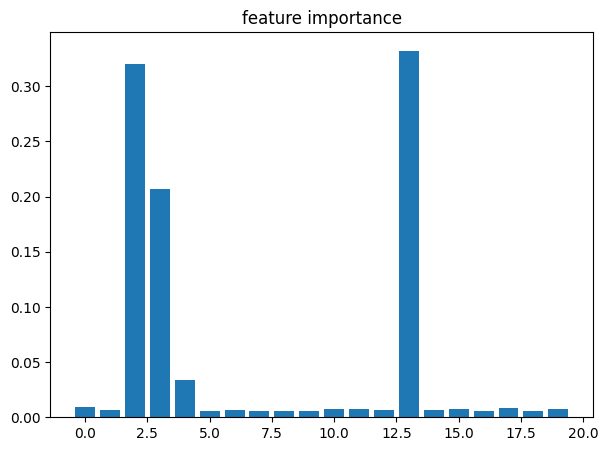

In [ ]:
#  변수선택시 RandomForest가 중요하게 사용
f, ax = plt.subplots(figsize=(7,5))
ax.bar(range(0, len(rf.feature_importances_)),
       rf.feature_importances_)
ax.set_title('feature importance')

In [ ]:
print("종속변수객수", rf.n_classes_)
print("클래스종류", rf.classes_ )
print("특성수", rf.n_features_in_)
print("모델", rf.estimators_ ) #DecisionTreeClassifier

종속변수객수 2
클래스종류 [0 1]
특성수 20
모델 [DecisionTreeClassifier(max_features='sqrt', random_state=463220222), DecisionTreeClassifier(max_features='sqrt', random_state=1585635694), DecisionTreeClassifier(max_features='sqrt', random_state=614845842), DecisionTreeClassifier(max_features='sqrt', random_state=1581768228), DecisionTreeClassifier(max_features='sqrt', random_state=1812122371), DecisionTreeClassifier(max_features='sqrt', random_state=1945436483), DecisionTreeClassifier(max_features='sqrt', random_state=54614555), DecisionTreeClassifier(max_features='sqrt', random_state=759953504), DecisionTreeClassifier(max_features='sqrt', random_state=1683044534), DecisionTreeClassifier(max_features='sqrt', random_state=1929036739), DecisionTreeClassifier(max_features='sqrt', random_state=1408797548), DecisionTreeClassifier(max_features='sqrt', random_state=1039533272), DecisionTreeClassifier(max_features='sqrt', random_state=591477459), DecisionTreeClassifier(max_features='sqrt', random_state=4378762

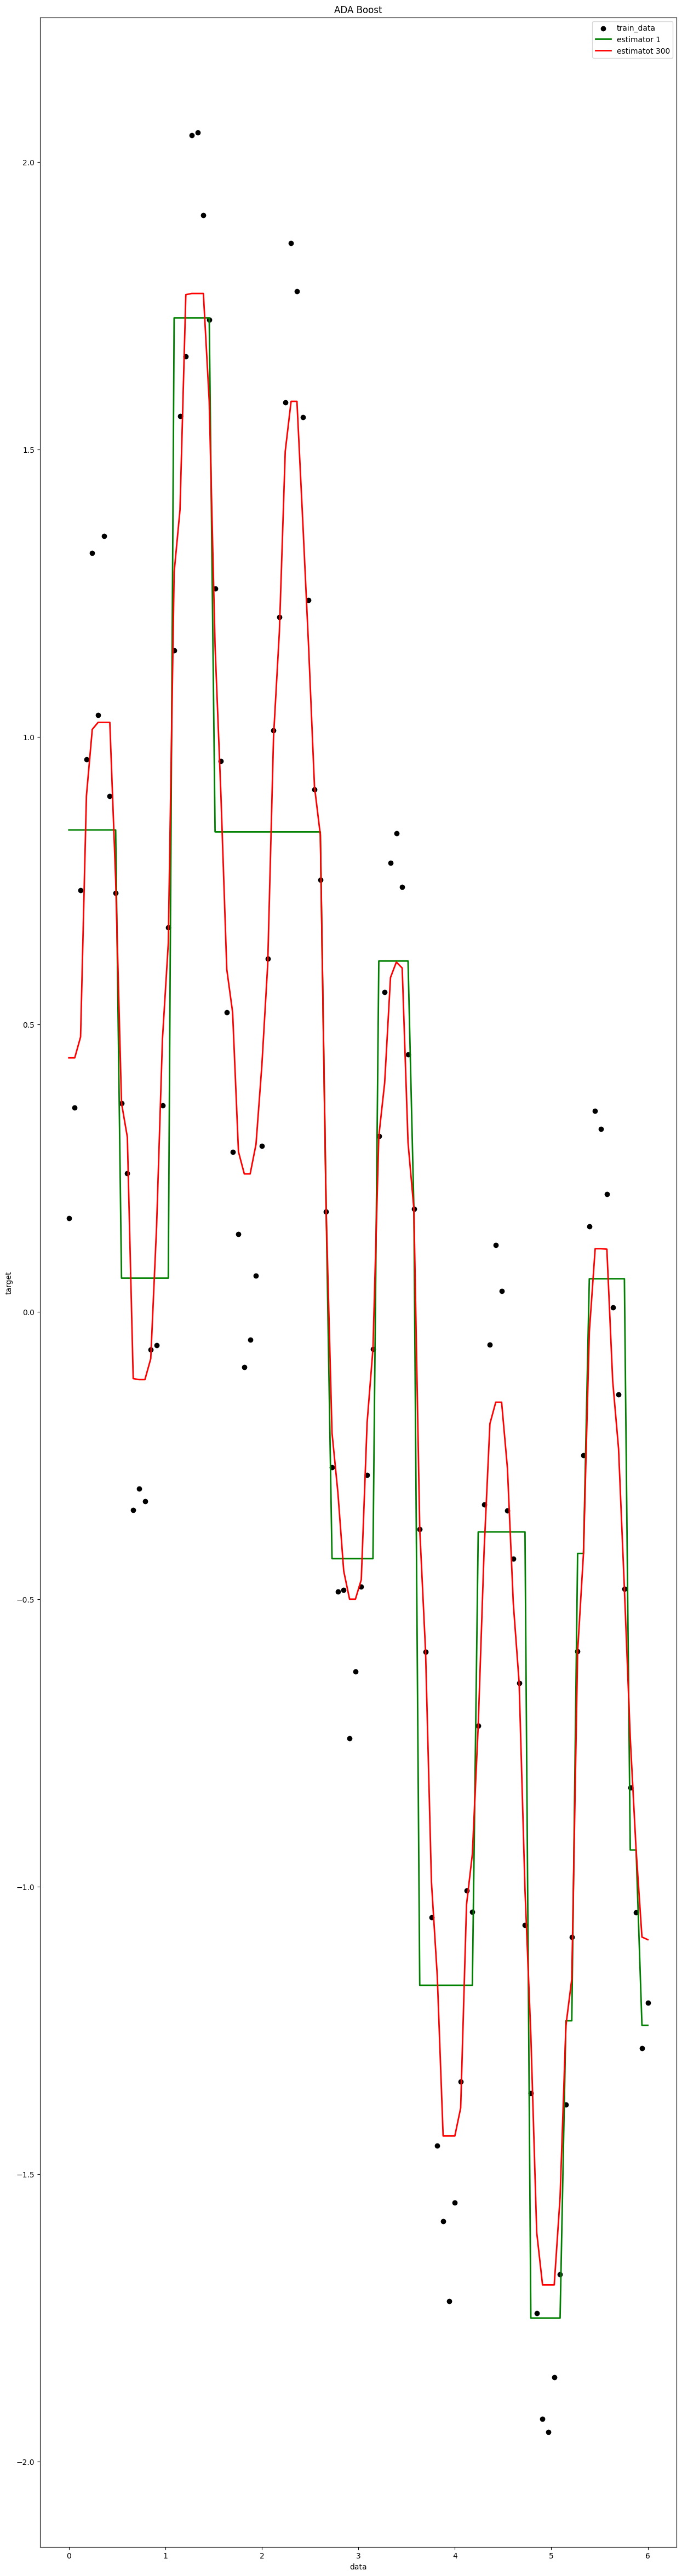

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
import numpy as np
# DecisionTreeRegressor : 단일 결정 트리로 데이터를 학습하는 회귀 모델
rng = np.random.RandomState(1)
X = np.linspace(0, 6, 100)[:, np.newaxis]
y = np.sin(X).ravel() + np.sin(6*X).ravel() + rng.normal(0, 0.1, X.shape[0])
regr_1 = DecisionTreeRegressor(max_depth=4)
regr_2 = AdaBoostRegressor(DecisionTreeRegressor(
    max_depth=4),
                           n_estimators=300, random_state=rng)
regr_1.fit(X, y)
regr_2.fit(X, y)
y_1 = regr_1.predict(X)
y_2 = regr_2.predict(X)
plt.figure()
plt.scatter(X, y, c="k", label="train_data")
# scatter(X, y, c="k", label="train_data") : 원본 데이터( 검은 점 )
plt.plot(X, y_1, c="g", label="estimator 1", linewidth=2)
# plot(X, y_1, c="g", label="estimator 1"): 단일 결정 트리 예측 결과(녹색 선)
plt.plot(X, y_2, c="r", label="estimatot 300", linewidth=2)
# plot(X, y_2, c="r", label="estimator 300"): AdaBoost 예측 결과(빨간 선, 더 부드러움)
plt.xlabel("data")
plt.ylabel("target")
plt.title("ADA Boost")
plt.legend()
plt.show()


In [ ]:
# adaboost나 Bagging이나 기본 베이스를 다른 모델로 해도 됨
# Bagging = Bootstrap + Aggregation
# 데이터 증강 -> 집계( 이산- 투표, 연속-평균)
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
iris = load_iris()
X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42),
    n_estimators=10,
    max_samples=100, bootstrap=True, n_jobs=-1,
    random_state=42, oob_score=True)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
print('Accuracy =', accuracy_score(y_test, y_pred))
bag_clf.oob_score


Accuracy = 1.0


True

In [ ]:
print(f"🔹 X_train.shape: {X_train.shape}")
print(f"🔹 y_train.shape: {y_train.shape}")

🔹 X_train.shape: (120, 4)
🔹 y_train.shape: (120,)


In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'estimator__max_depth' : [3, 4, 5, 6],
    'max_samples': [0.01, 0.05, 0.1, 0.2]
}
from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(BaggingClassifier(DecisionTreeClassifier(
    random_state=42), n_estimators = 10, max_samples=100,
    bootstrap=True, n_jobs=-1, random_state=42,
    max_features = 0.5), param_grid)
clf.fit(X_train, y_train)

GridSearchCV(estimator=BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42),
                                         max_features=0.5, max_samples=100,
                                         n_jobs=-1, random_state=42),
             param_grid={'estimator__max_depth': [3, 4, 5, 6],
                         'max_samples': [0.01, 0.05, 0.1, 0.2]})

In [ ]:
import pickle
s = pickle.dumps(clf) # 모델 clf를 메모리에서 문자열(byte)로 변환
print(s)
# 메모리에서 문자열로 변환 -> 네트워크로 모델을 전송
# 메모리 데이터베이스 : redis( 속도가 빠름 )

b'\x80\x04\x952B\x00\x00\x00\x00\x00\x00\x8c\x1fsklearn.model_selection._search\x94\x8c\x0cGridSearchCV\x94\x93\x94)\x81\x94}\x94(\x8c\x07scoring\x94N\x8c\testimator\x94\x8c\x19sklearn.ensemble._bagging\x94\x8c\x11BaggingClassifier\x94\x93\x94)\x81\x94}\x94(h\x06\x8c\x15sklearn.tree._classes\x94\x8c\x16DecisionTreeClassifier\x94\x93\x94)\x81\x94}\x94(\x8c\tcriterion\x94\x8c\x04gini\x94\x8c\x08splitter\x94\x8c\x04best\x94\x8c\tmax_depth\x94N\x8c\x11min_samples_split\x94K\x02\x8c\x10min_samples_leaf\x94K\x01\x8c\x18min_weight_fraction_leaf\x94G\x00\x00\x00\x00\x00\x00\x00\x00\x8c\x0cmax_features\x94N\x8c\x0emax_leaf_nodes\x94N\x8c\x0crandom_state\x94K*\x8c\x15min_impurity_decrease\x94G\x00\x00\x00\x00\x00\x00\x00\x00\x8c\x0cclass_weight\x94N\x8c\tccp_alpha\x94G\x00\x00\x00\x00\x00\x00\x00\x00\x8c\rmonotonic_cst\x94N\x8c\x10_sklearn_version\x94\x8c\x051.6.1\x94ub\x8c\x0cn_estimators\x94K\n\x8c\x10estimator_params\x94)\x8c\x0bmax_samples\x94Kdh\x19G?\xe0\x00\x00\x00\x00\x00\x00\x8c\tbootst

In [ ]:
clf2 = pickle.loads(s) # 메모리에서 다시 모델 로드
clf2.predict(X_test) # 로드한 모델로 예측 수행

array([1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 2,
       0, 2, 2, 2, 2, 2, 0, 0])

In [ ]:
# importatn라는 파일에 모델을 바이너리(wb) 형식으로 저장
file = open('important', 'wb') # type : write binary
pickle.dump(clf, file) # 모델을 파일에 직렬화하여 저장
file.close() # 파일을 닫아야 데이터가 정상적으로 저장됨
# 파일, 네트워크, 데이터베이스는 os가 관리

In [ ]:
file = open('important', 'rb') # read binary
clf2 = pickle.load(file) # 저장된 모델 불러오기
print(clf2.predict(X_test)) # 예측 수행
file.close()

[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0]


In [ ]:
clf2= pickle.loads(s)
clf2.predict(X_test)

array([1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 2,
       0, 2, 2, 2, 2, 2, 0, 0])

In [ ]:
import pandas as pd
file_path='/content/drive/MyDrive/Numpy/Wine.csv'
data = pd.read_csv(file_path)

In [ ]:
data.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline,Customer_Segment
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1


In [ ]:
print(data.isnull().sum())
data.info()
print(data)

Alcohol                 0
Malic_Acid              0
Ash                     0
Ash_Alcanity            0
Magnesium               0
Total_Phenols           0
Flavanoids              0
Nonflavanoid_Phenols    0
Proanthocyanins         0
Color_Intensity         0
Hue                     0
OD280                   0
Proline                 0
Customer_Segment        0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Alcohol               178 non-null    float64
 1   Malic_Acid            178 non-null    float64
 2   Ash                   178 non-null    float64
 3   Ash_Alcanity          178 non-null    float64
 4   Magnesium             178 non-null    int64  
 5   Total_Phenols         178 non-null    float64
 6   Flavanoids            178 non-null    float64
 7   Nonflavanoid_Phenols  178 non-null    float64
 8   Pro

In [ ]:
# 필요한 라이브러리 불러오기
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# 1. 데이터 로드
file_path = "/content/drive/MyDrive/Numpy/Wine.csv"
df = pd.read_csv(file_path)

# 2. 데이터 전처리
X = df.drop(columns=['Customer_Segment'])  # 독립변수
y = df['Customer_Segment']  # 종속변수

scaler = StandardScaler()  # 표준화
X_scaled = scaler.fit_transform(X)

# 학습/테스트 데이터 분리 (8:2 비율)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# 3. 랜덤포레스트 모델 학습 (튜닝된 하이퍼파라미터 적용)
optimized_rf_model = RandomForestClassifier(
    n_estimators=100,      # 트리 개수
    max_depth=10,          # 최대 깊이
    min_samples_split=5,   # 노드 분할 최소 샘플 수
    min_samples_leaf=2,    # 리프 노드 최소 샘플 수
    random_state=42
)

optimized_rf_model.fit(X_train, y_train)  # 모델 학습

# 4. 예측 및 평가
y_pred_optimized = optimized_rf_model.predict(X_test)
optimized_accuracy = accuracy_score(y_test, y_pred_optimized)

print(f"최종 모델 테스트 정확도: {optimized_accuracy:.2f}")


최종 모델 테스트 정확도: 1.00
